In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#visualization
import missingno as msno
import seaborn as sns 
from matplotlib.gridspec import GridSpec

#data preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import RobustScaler

#model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

#evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

In [3]:
#read data into a pandas dataframe
yellow_taxi_trip_jan_2023_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet"
yellow_taxi_trip_feb_2023_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet"
jan_2023 = pd.read_parquet(yellow_taxi_trip_jan_2023_path)
feb_2023 = pd.read_parquet(yellow_taxi_trip_feb_2023_path)

In [4]:
print("jan shape", jan_2023.shape)
print("feb shape", feb_2023.shape)

jan shape (3066766, 19)
feb shape (2913955, 19)


In [5]:
jan_2023.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [6]:
feb_2023.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00


#### STRUCTURAL INVESTIGATION 

In [7]:

def data_info(df):
    """
    function takes a dataframe and returns a dataframe containing basic feature info of the dataframe
    """
    info_df = pd.DataFrame([df.isna().sum(),
                            round(df.isna().sum()*100 / df.shape[0],2), df.nunique(), df.dtypes], 
                            index=["missing_val","missing_val_percent","number_of_unique_val","data_types" ])
    
    return info_df



In [8]:
data_info(jan_2023).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
missing_val,0,0,0,71743,0,71743,71743,0,0,0,0,0,0,0,0,0,0,71743,71743
missing_val_percent,0.0,0.0,0.0,2.34,0.0,2.34,2.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.34,2.34
number_of_unique_val,2,1610975,1611319,10,4387,7,2,257,261,5,6873,68,10,4036,776,5,15871,3,3
data_types,int64,datetime64[us],datetime64[us],float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [9]:
data_info(feb_2023).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
missing_val,0,0,0,76817,0,76817,76817,0,0,0,0,0,0,0,0,0,0,76817,76817
missing_val_percent,0.0,0.0,0.0,2.64,0.0,2.64,2.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.64,2.64
number_of_unique_val,3,1493984,1493635,10,4314,7,2,258,261,5,6596,136,6,4009,726,5,15701,4,3
data_types,int32,datetime64[us],datetime64[us],float64,float64,float64,object,int32,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [10]:
#function to ingest data and output a pandas DataFrame
#with a target label
def create_target_label(df):
    """
    Create a target variable column by subtracting the trip pick up from drop off and converts it minutes with data type of float for easy visualization and analysis.
    """
    #create the duration 
    df["trip_duration_mins"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["trip_duration_mins"] = df["trip_duration_mins"].dt.total_seconds().map(lambda x:round(x/60,2))

    return df

In [11]:
main_df = create_target_label(jan_2023)
main_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.43
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.32
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.75
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.62
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.83


In [12]:
#print missing data
main_df.isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
trip_duration_mins           0
dtype: int64

<Axes: >

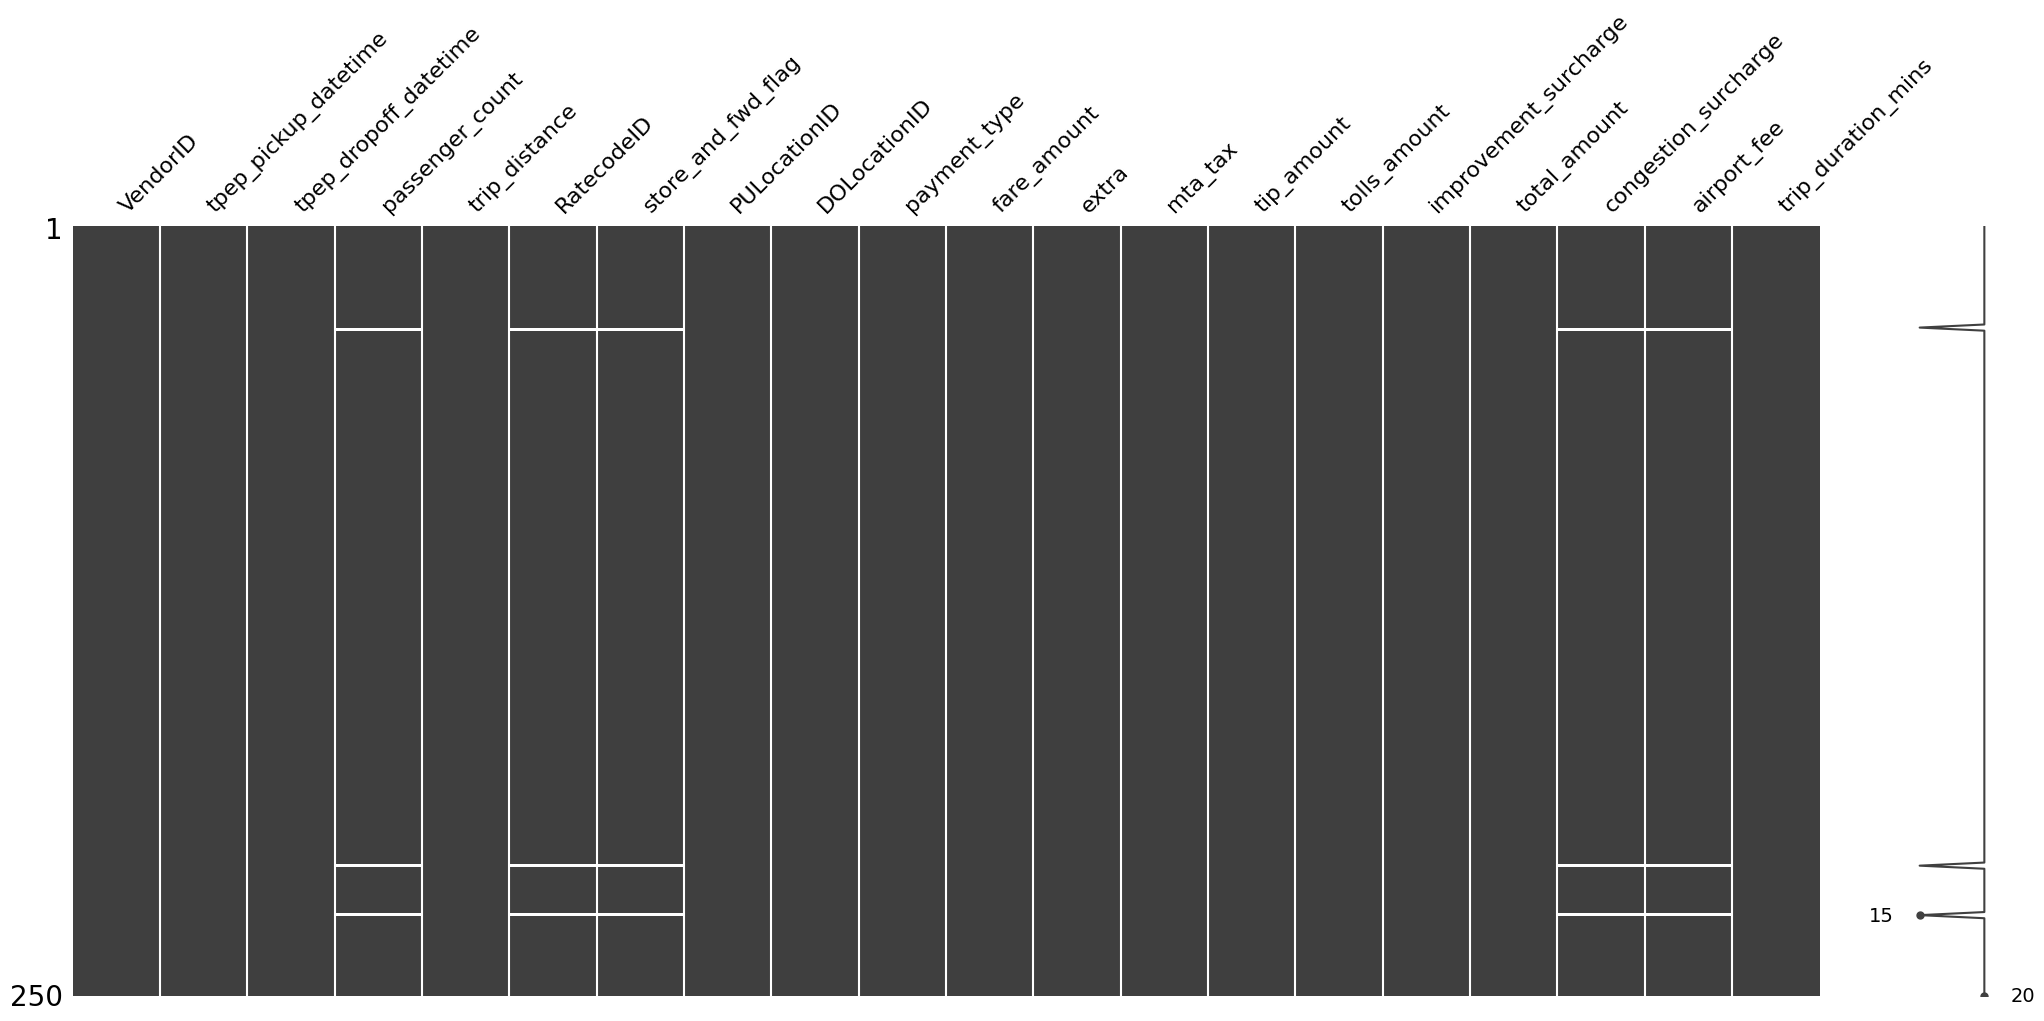

In [13]:
#visualize missing data 
msno.matrix(main_df.sample(250))

From  the above missing data visualition, it can be observed that the missing observations appear to be uniform accross affected features and all share the same index

In [14]:
data_info(main_df)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
missing_val,0,0,0,71743,0,71743,71743,0,0,0,0,0,0,0,0,0,0,71743,71743,0
missing_val_percent,0.0,0.0,0.0,2.34,0.0,2.34,2.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.34,2.34,0.0
number_of_unique_val,2,1610975,1611319,10,4387,7,2,257,261,5,6873,68,10,4036,776,5,15871,3,3,8579
data_types,int64,datetime64[us],datetime64[us],float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [15]:
# treat missing values
def treat_na(df):
    """
    This function converts features to appropriate data types,
    checks for percentage of missing values, drops features with missing values above 49 percent
    or else fill missing values with linear interpolation for continous data, and mode for categorical data
    """ 
    cat_1 = pd.CategoricalDtype(categories=[1,2,3,4,5,6], ordered=True)
    df["RatecodeID"] = df["RatecodeID"].astype(cat_1)
    df["payment_type"] = df["payment_type"].astype(cat_1)
    df["store_and_fwd_flag"] = df["store_and_fwd_flag"].astype("category")
    df["PULocationID"] = df["PULocationID"].astype("category")
    df["DOLocationID"] = df["DOLocationID"].astype("category")

    percent = round(df.isna().sum() * 100/df.shape[0] ,2)

    #loop through item
    for index, item in percent.items():
        if item > 49:
            df = df.drop(columns=[index])
        else:
            #fill missing categorical observations with mode
            if df[index].dtype == "category":
                df[index] = df[index].fillna(df[index].mode()[0])
            else: 
                #use linear interpolation for other data types
                df[index] = df[index].fillna(df[index].median())
    return df
    

In [16]:
#check function
main_df_2 = treat_na(main_df)
data_info(main_df_2).head() 
    

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
missing_val,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing_val_percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
number_of_unique_val,2,1610975,1611319,10,4387,6,2,257,261,4,6873,68,10,4036,776,5,15871,3,3,8579
data_types,int64,datetime64[us],datetime64[us],float64,float64,category,category,category,category,category,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [17]:
#Get statistical information of data
main_df_2.describe(include="all")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
count,3.066766e+06,3066766,3066766,3.066766e+06,3.066766e+06,3066766.0,3066766,3066766.0,3066766.0,3066766.0,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06
unique,NaN,NaN,NaN,NaN,NaN,6.0,2,257.0,261.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,1.0,N,132.0,236.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,2924154.0,3046763,160030.0,146348.0,2483205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.730215e+00,2023-01-17 00:22:26.288164,2023-01-17 00:38:06.427874,1.354051e+00,3.847342e+00,NaN,NaN,NaN,NaN,NaN,1.836707e+01,1.537842e+00,4.882900e-01,3.367941e+00,5.184907e-01,9.820847e-01,2.702038e+01,2.279513e+00,1.048959e-01,1.566899e+01
min,1.000000e+00,2008-12-31 23:01:42,2009-01-01 14:29:11,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,-9.000000e+02,-7.500000e+00,-5.000000e-01,-9.622000e+01,-6.500000e+01,-1.000000e+00,-7.510000e+02,-2.500000e+00,-1.250000e+00,-2.920000e+01
25%,1.000000e+00,2023-01-09 16:21:57.250000,2023-01-09 16:37:06,1.000000e+00,1.060000e+00,NaN,NaN,NaN,NaN,NaN,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.540000e+01,2.500000e+00,0.000000e+00,7.120000e+00
50%,2.000000e+00,2023-01-17 08:42:29.500000,2023-01-17 08:58:30.500000,1.000000e+00,1.800000e+00,NaN,NaN,NaN,NaN,NaN,1.280000e+01,1.000000e+00,5.000000e-01,2.720000e+00,0.000000e+00,1.000000e+00,2.016000e+01,2.500000e+00,0.000000e+00,1.152000e+01
75%,2.000000e+00,2023-01-24 16:26:27,2023-01-24 16:42:49,1.000000e+00,3.330000e+00,NaN,NaN,NaN,NaN,NaN,2.050000e+01,2.500000e+00,5.000000e-01,4.200000e+00,0.000000e+00,1.000000e+00,2.870000e+01,2.500000e+00,0.000000e+00,1.830000e+01
max,2.000000e+00,2023-02-01 00:56:53,2023-02-02 09:28:47,9.000000e+00,2.589281e+05,NaN,NaN,NaN,NaN,NaN,1.160100e+03,1.250000e+01,5.316000e+01,3.808000e+02,1.969900e+02,1.000000e+00,1.169400e+03,2.500000e+00,1.250000e+00,1.002918e+04


From the statistical information, possible outliers can be detected in most of the features from the negative values present, this can be attibuted pick off and drop off time from the values that are not related january 2023. Further deductions will be made from the distributions

#### Create plots for the features to visualize distribution and investigate outliers.

##### *Categorical Data*

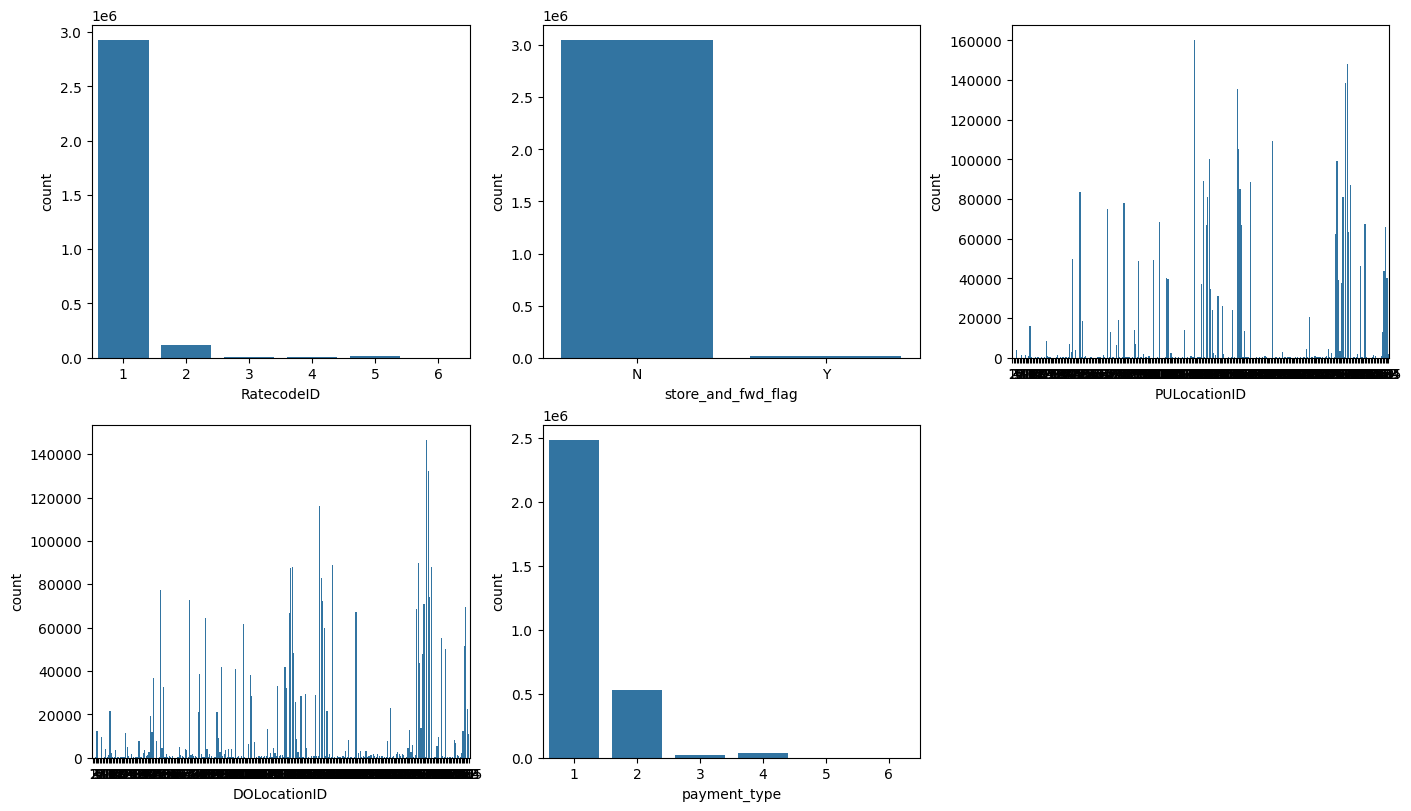

In [18]:

#list of categorical variables
cat_columns = [column for column, val in main_df_2.items() if val.dtype == "category"]

#pyplot figure object 
fig = plt.figure(layout="constrained", figsize = (14,8))
gs = GridSpec(2,3, figure=fig)
plot = 0 #count for the 

for i in range(2): #for row number
    for j in range(3): #for column number
        if plot < 5:
            ax_ = fig.add_subplot(gs[i,j]) # assign axes objects at current row and column
            sns.countplot(x= main_df_2.loc[:,cat_columns[plot]])
            plot += 1
plt.show()        


The pick up and drop off location id appears to have no pattern, while most trips were charged with the standard rate and payment made through credit card.

#####  *Numerical Data*

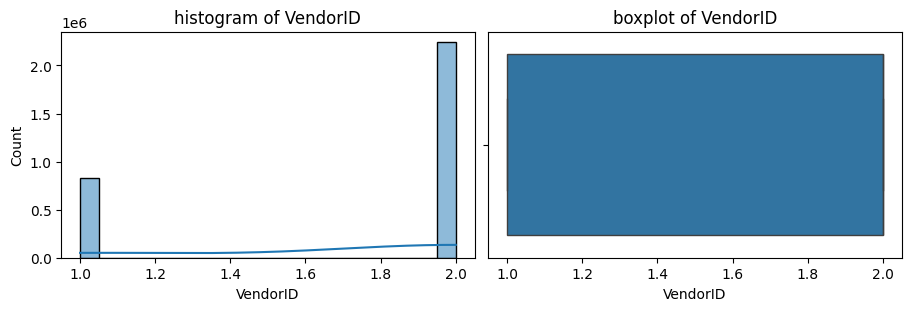

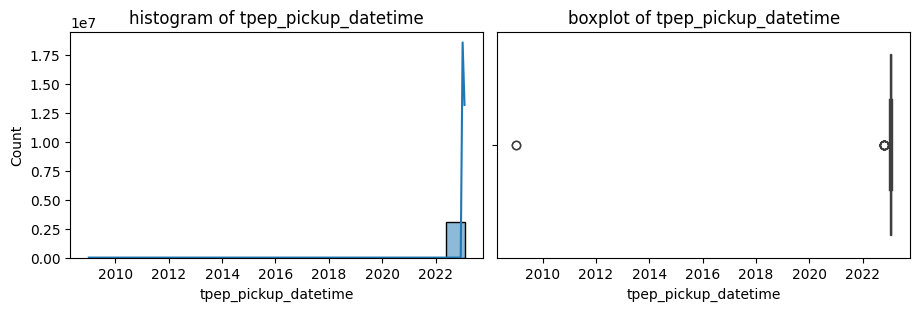

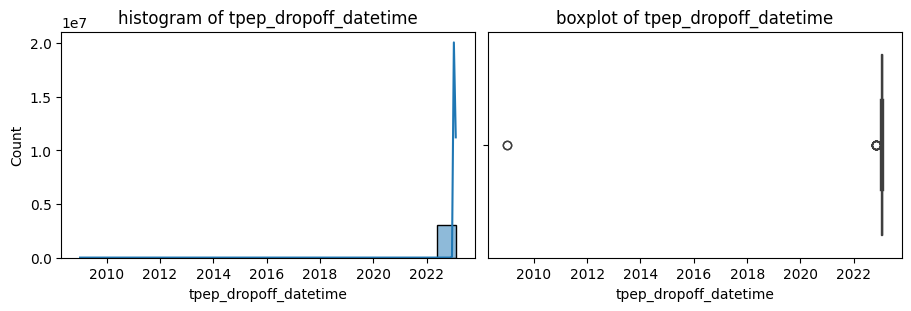

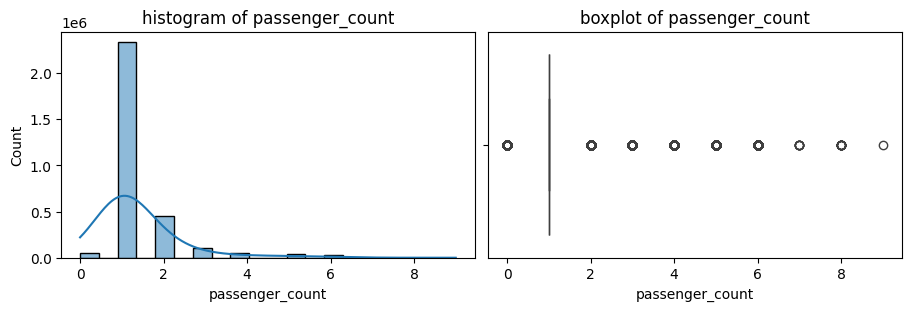

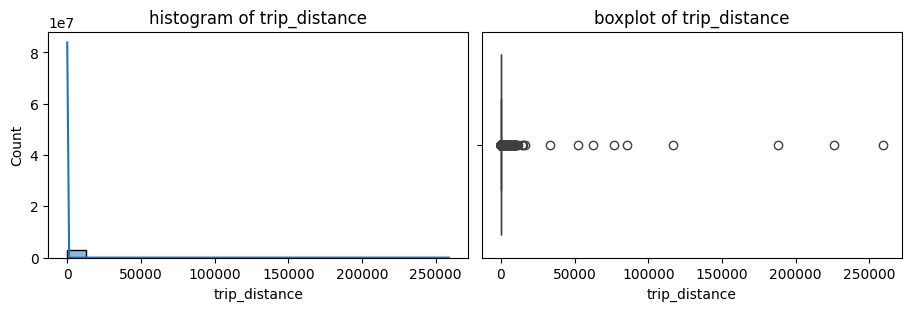

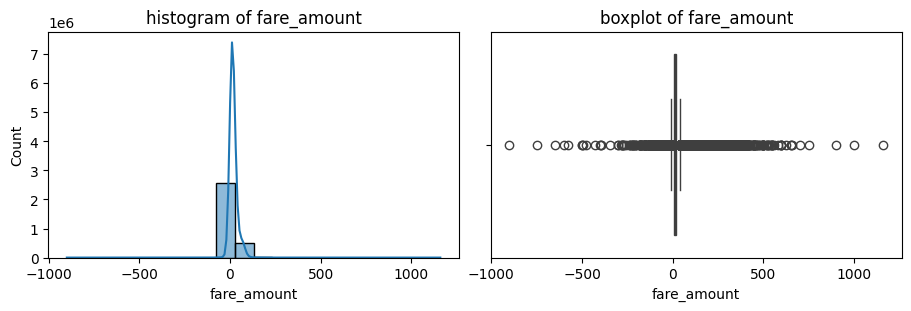

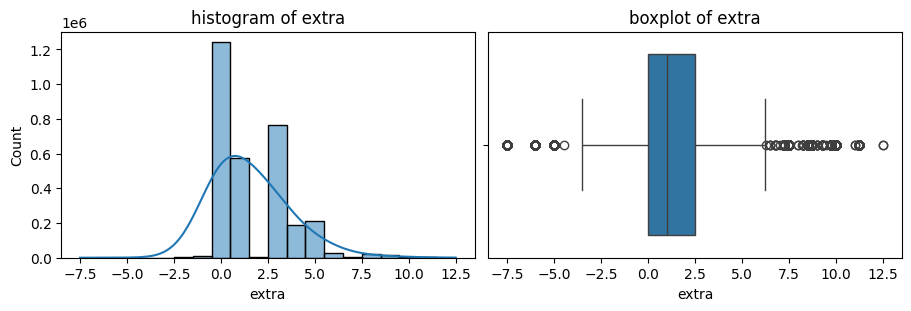

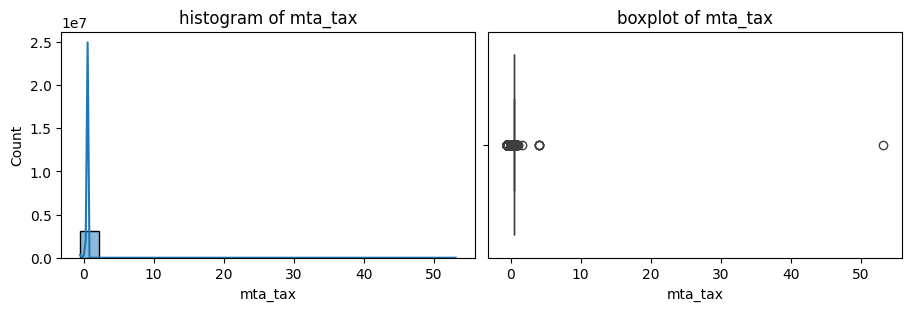

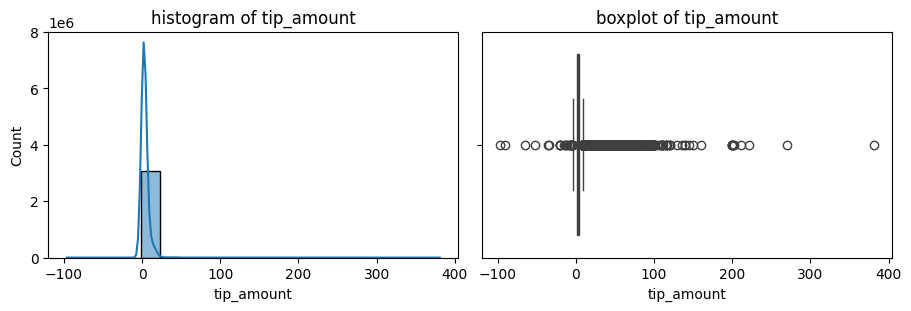

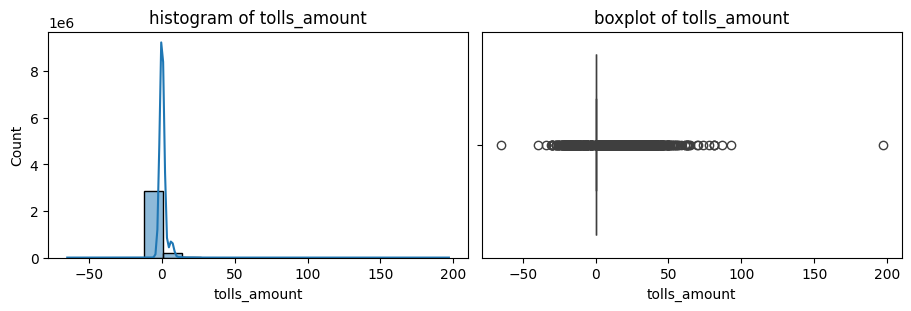

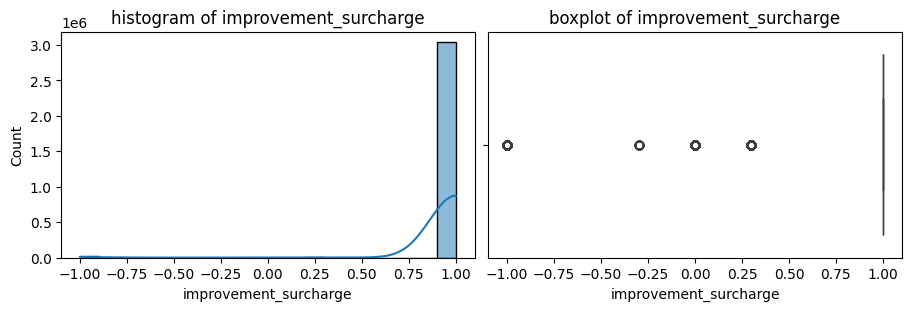

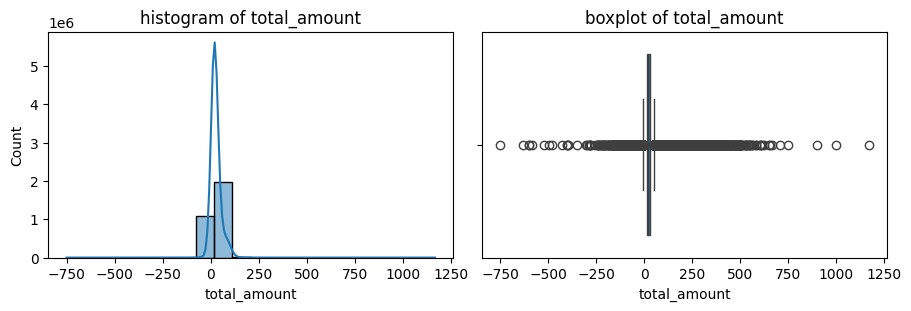

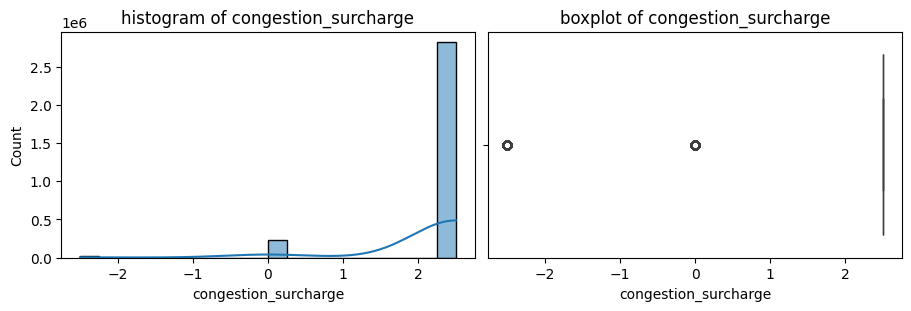

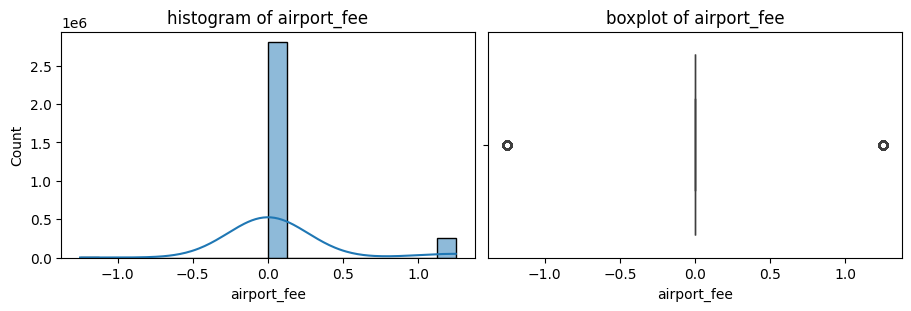

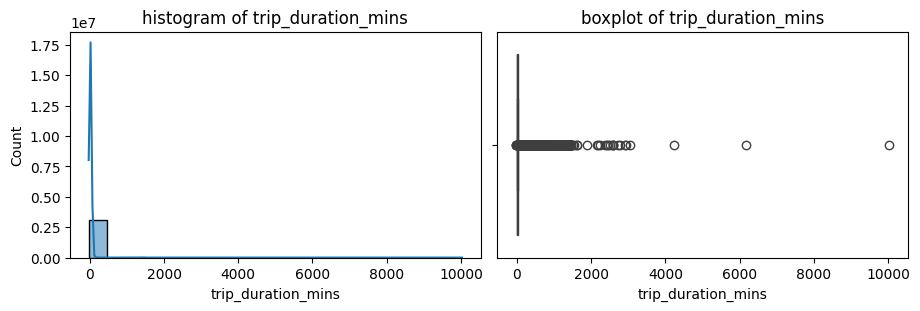

In [19]:

# list of numerical features
non_cat_columns = [column for column in main_df_2.columns if column not in cat_columns]

for col in non_cat_columns:
  fig, axs = plt.subplots(1,2,figsize=(9,3), layout="constrained")

  sns.histplot(x= main_df_2.loc[:,col], bins=20, ax=axs[0], kde=True, kde_kws={"bw_adjust": 15}) #plot histogram with a kernel density of 15 to observe distribution
  axs[0].set_title(f"histogram of {col}")
  sns.boxplot(x=main_df_2.loc[:,col], ax=axs[1]) #Create boxplot for further visualization of outliers 
  axs[1].set_title(f"boxplot of {col}")
  plt.show() 


Negative values present in the total amount paid are possible outliers as there cannot be negative values for total trip amount charges. Also, outliers can be detected in the trip pick up and drop off time as in values that are outside the date range of our data. outliers can also be detected in other features. According to the data card, extra should either be 0.5 or 1 dollars, mta_tax should 0.5 dollars which is automatically triggered, improvement surcharge should be 0.3. 

In [20]:
#Get kurtosis for numeric features using fishers definition 
main_df_2.kurtosis(numeric_only=True)

VendorID                     -0.923883
passenger_count               9.828206
trip_distance            726436.933362
fare_amount                  49.554467
extra                         2.128370
mta_tax                   21970.425452
tip_amount                   92.756546
tolls_amount                 78.699510
improvement_surcharge       109.465794
total_amount                 26.595788
congestion_surcharge         12.863855
airport_fee                   6.813302
trip_duration_mins         2167.725431
dtype: float64

The large positive values of kurtosis shows the heavey presence of outliers in most of the features.

In [21]:
#set minimum number of display rows to 40 for better visualization of the dataFrame.
pd.set_option("display.min_rows", 40)

#sort values according to the pickup and drop off time
main_df_2.sort_values(by="tpep_pickup_datetime")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
2138036,2,2008-12-31 23:01:42,2009-01-01 14:29:11,1.0,17.76,2,N,132,230,2,70.0,0.00,0.5,0.00,6.55,1.0,80.55,2.5,0.00,927.48
209091,2,2008-12-31 23:04:41,2009-01-01 19:55:36,1.0,0.00,1,N,7,7,2,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,1250.92
10023,2,2022-10-24 17:37:47,2022-10-24 17:37:51,1.0,0.00,5,N,1,1,2,120.0,0.00,0.0,0.00,0.00,0.3,120.30,0.0,0.00,0.07
18219,2,2022-10-24 20:01:46,2022-10-24 20:01:48,1.0,0.00,5,N,17,17,1,45.0,0.00,0.0,9.06,0.00,0.3,54.36,0.0,0.00,0.03
21660,2,2022-10-24 21:45:35,2022-10-24 21:45:38,1.0,0.00,5,N,48,264,1,75.0,0.00,0.0,15.06,0.00,0.3,90.36,0.0,0.00,0.05
22489,2,2022-10-24 23:15:32,2022-10-24 23:15:42,1.0,0.00,5,N,211,211,1,55.0,0.00,0.0,14.45,0.00,0.3,72.25,2.5,0.00,0.17
24577,2,2022-10-25 00:42:10,2022-10-25 00:44:22,1.0,0.97,1,N,132,132,2,4.5,0.00,0.5,0.00,0.00,0.3,6.55,0.0,1.25,2.20
24578,2,2022-10-25 00:59:02,2022-10-25 01:09:02,1.0,2.33,1,N,265,265,2,10.0,0.00,0.5,0.00,0.00,0.3,10.80,0.0,0.00,10.00
31916,2,2022-10-25 03:45:46,2022-10-25 03:45:50,1.0,0.02,5,N,1,1,1,115.0,0.00,0.0,5.00,0.00,0.3,120.30,0.0,0.00,0.07
47843,2,2022-10-25 07:48:15,2022-10-25 07:48:18,2.0,0.76,5,N,132,264,1,78.0,0.00,0.5,15.76,0.00,0.3,94.56,0.0,0.00,0.05


Since our data is meant to contain only observations from january 2023, then every observation that is not within the date range of 2023-01-01 to 2023-01-31 in the trip pick up time will be treated as outliers and dropped from the dataframe.

In [22]:

#sort dataframe values by trip duration
main_df_2.sort_values(by="trip_duration_mins")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
1839180,1,2023-01-20 13:35:00,2023-01-20 13:05:48,1.0,0.80,1,N,227,14,1,16.50,0.00,0.5,0.00,0.00,1.0,18.00,0.0,0.00,-29.20
2218504,1,2023-01-24 11:00:00,2023-01-24 10:40:48,1.0,0.40,1,N,247,169,1,15.50,0.00,0.5,0.00,0.00,1.0,17.00,0.0,0.00,-19.20
2124414,1,2023-01-23 10:43:58,2023-01-23 10:29:26,1.0,2.40,1,N,102,82,1,21.50,0.00,0.5,0.00,0.00,1.0,23.00,0.0,0.00,-14.53
1188757,1,2023-01-13 21:51:39,2023-01-13 21:51:39,1.0,0.00,1,N,137,264,2,3.00,3.50,0.5,0.00,0.00,1.0,8.00,2.5,0.00,0.00
2575201,1,2023-01-27 17:49:53,2023-01-27 17:49:53,2.0,0.00,1,N,142,264,2,11.40,5.00,0.5,0.00,0.00,1.0,17.90,2.5,0.00,0.00
119345,1,2023-01-02 18:14:48,2023-01-02 18:14:48,1.0,0.00,1,N,162,264,2,5.80,2.50,0.5,0.00,0.00,1.0,9.80,2.5,0.00,0.00
1332740,1,2023-01-15 09:32:36,2023-01-15 09:32:36,1.0,0.00,1,Y,132,264,2,21.90,1.25,0.5,0.00,0.00,1.0,24.65,0.0,1.25,0.00
1721985,1,2023-01-19 12:45:50,2023-01-19 12:45:50,1.0,0.00,1,Y,43,264,2,11.40,2.50,0.5,0.00,0.00,1.0,15.40,2.5,0.00,0.00
1603440,1,2023-01-18 10:06:36,2023-01-18 10:06:36,0.0,0.00,1,Y,229,264,2,17.00,2.50,0.5,0.00,0.00,1.0,21.00,2.5,0.00,0.00
1188543,1,2023-01-13 21:43:58,2023-01-13 21:43:58,1.0,0.00,2,Y,93,264,2,70.00,2.50,0.5,0.00,6.55,1.0,80.55,0.0,0.00,0.00


From the sorted values by trip duration, there appears to be negative values which may be due to a faulty meter reading. Also the largest trip duration corresponds to a o trip distance, which is also a possible outlier and will not be of much good to the model. Negative values for trip duration will be dropped.

In [23]:
#sort dataframe values by trip distance
main_df_2.sort_values(by="trip_distance")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
790414,2,2023-01-10 07:24:36,2023-01-10 07:24:58,1.0,0.00,2,N,234,234,1,70.00,0.00,0.5,12.00,6.55,1.0,93.80,2.5,1.25,0.37
1996515,2,2023-01-21 20:01:30,2023-01-21 20:01:40,1.0,0.00,5,N,235,235,1,76.30,0.00,0.0,0.00,6.55,1.0,85.10,0.0,1.25,0.17
1996535,1,2023-01-21 20:26:08,2023-01-21 20:26:35,1.0,0.00,2,N,48,48,1,70.00,2.50,0.5,0.00,6.55,1.0,80.55,2.5,0.00,0.45
1996651,2,2023-01-21 20:58:21,2023-01-21 20:58:23,1.0,0.00,1,N,264,264,2,3.00,1.00,0.5,0.00,0.00,1.0,5.50,0.0,0.00,0.03
1996656,1,2023-01-21 20:07:22,2023-01-21 20:07:46,1.0,0.00,1,N,107,107,3,3.00,3.50,0.5,0.00,0.00,1.0,8.00,2.5,0.00,0.40
1166716,2,2023-01-13 18:37:17,2023-01-13 18:37:30,1.0,0.00,5,N,132,132,1,15.00,0.00,0.0,0.00,0.00,1.0,17.25,0.0,1.25,0.22
316743,1,2023-01-05 01:09:57,2023-01-05 01:10:19,0.0,0.00,5,N,142,142,1,70.00,0.00,0.0,5.00,0.00,1.0,76.00,0.0,0.00,0.37
1996712,1,2023-01-21 20:55:13,2023-01-21 20:55:32,1.0,0.00,1,N,132,132,3,3.00,2.25,0.5,0.00,0.00,1.0,6.75,0.0,1.25,0.32
1996805,2,2023-01-21 20:11:44,2023-01-21 20:31:22,1.0,0.00,1,N,211,137,1,16.30,1.00,0.5,5.00,0.00,1.0,26.30,2.5,0.00,19.63
1996806,2,2023-01-21 20:34:08,2023-01-21 20:53:19,1.0,0.00,1,N,137,114,1,16.30,1.00,0.5,4.26,0.00,1.0,25.56,2.5,0.00,19.18


There appears to be inconsistencies between trip distance and trip duration in relation with the larger values of distance with the largest value of trip distance corresponding to a very short trip duration. A scatter plot will be used to visualize this relationship and investigate the pattern.

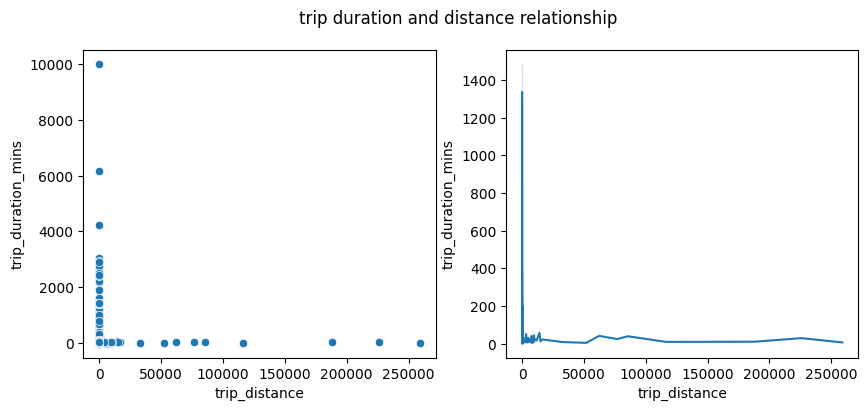

In [24]:
fig,axs= plt.subplots(1,2,figsize=(10,4))
sns.scatterplot(data=main_df_2, x="trip_distance", y="trip_duration_mins",ax=axs[0])
sns.lineplot(data=main_df_2, x="trip_distance", y="trip_duration_mins",ax=axs[1])
fig.suptitle("trip duration and distance relationship")
plt.show()

The scatter plot and line plot shows a negative relationship beteen trip duration and distance, as can be observed, larger values of either feature corresponds to low values of even zero of the other. This may be due to the presence of outliers in the features.

In [25]:
#sort dataframe by fareamount
main_df_2.sort_values(by="fare_amount")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
2849549,2,2023-01-30 13:17:33,2023-01-30 13:17:48,1.0,0.00,5,N,182,182,3,-900.00,0.00,0.0,270.30,0.00,-1.0,-630.70,0.0,0.00,0.25
2849551,2,2023-01-30 13:23:56,2023-01-30 13:24:08,1.0,0.00,5,N,182,182,3,-750.00,0.00,0.0,0.00,0.00,-1.0,-751.00,0.0,0.00,0.20
2102835,2,2023-01-22 23:24:55,2023-01-22 23:25:02,1.0,0.00,5,N,48,48,3,-650.00,0.00,0.0,50.00,0.00,-1.0,-601.00,0.0,0.00,0.12
1506027,2,2023-01-17 10:04:34,2023-01-17 10:05:00,1.0,0.06,5,N,141,141,4,-600.00,0.00,0.0,0.00,0.00,-1.0,-603.50,-2.5,0.00,0.43
988278,2,2023-01-12 02:25:26,2023-01-12 02:42:14,3.0,10.28,5,N,42,148,4,-580.00,0.00,0.0,0.00,0.00,-1.0,-583.50,-2.5,0.00,16.80
1214194,2,2023-01-14 03:29:33,2023-01-14 03:30:26,4.0,0.00,5,N,265,265,4,-500.00,0.00,0.0,20.00,0.00,-1.0,-481.00,0.0,0.00,0.88
362048,2,2023-01-05 15:57:36,2023-01-05 17:54:49,2.0,71.63,4,N,132,265,4,-497.90,0.00,-0.5,99.88,0.00,-1.0,-400.77,0.0,-1.25,117.22
1849808,2,2023-01-20 15:39:16,2023-01-20 18:06:38,1.0,68.17,4,N,132,265,2,-495.10,0.00,-0.5,0.00,0.00,-1.0,-497.85,0.0,-1.25,147.37
780751,2,2023-01-09 22:44:50,2023-01-10 00:00:14,1.0,58.96,5,N,132,265,2,-480.00,0.00,0.0,1.00,-39.30,-1.0,-520.55,0.0,-1.25,75.40
2507345,2,2023-01-26 23:49:21,2023-01-27 01:16:18,1.0,68.38,4,N,162,265,4,-425.80,-1.00,-0.5,0.00,0.00,-1.0,-430.80,-2.5,0.00,86.95


negative values are present in some observations in the fare_amount feature.

In [26]:
#sort values by mta_tax
main_df_2.sort_values(by="mta_tax")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
1056689,2,2023-01-12 18:07:54,2023-01-12 18:30:12,1.0,3.87,1,N,236,79,4,-23.30,-2.50,-0.50,0.00,0.00,-1.0,-29.80,-2.5,0.00,22.30
736158,2,2023-01-09 14:45:28,2023-01-09 14:50:13,2.0,0.46,1,N,142,143,3,-5.80,0.00,-0.50,0.00,0.00,-1.0,-9.80,-2.5,0.00,4.75
2596475,2,2023-01-27 20:50:35,2023-01-27 20:54:04,1.0,0.53,1,N,170,233,4,-5.80,-1.00,-0.50,0.00,0.00,-1.0,-10.80,-2.5,0.00,3.48
1378063,2,2023-01-15 17:42:12,2023-01-15 18:32:33,1.0,22.44,1,N,132,265,4,-86.30,0.00,-0.50,0.00,-6.55,-1.0,-95.60,0.0,-1.25,50.35
943399,2,2023-01-11 17:15:21,2023-01-11 17:15:26,1.0,0.00,1,N,193,193,3,-3.00,-2.50,-0.50,0.00,0.00,-1.0,-7.00,0.0,0.00,0.08
289681,2,2023-01-04 18:54:03,2023-01-04 19:08:58,1.0,2.44,1,N,143,236,2,-16.30,-2.50,-0.50,0.00,0.00,-1.0,-22.80,-2.5,0.00,14.92
198255,2,2023-01-03 17:53:40,2023-01-03 18:28:16,3.0,6.17,1,N,75,179,4,-33.80,-2.50,-0.50,0.00,0.00,-1.0,-40.30,-2.5,0.00,34.60
684666,2,2023-01-08 19:49:35,2023-01-08 20:24:07,1.0,16.66,2,N,132,229,4,-70.00,0.00,-0.50,0.00,0.00,-1.0,-75.25,-2.5,-1.25,34.53
385989,2,2023-01-05 18:48:09,2023-01-05 18:55:14,1.0,1.30,1,N,140,236,4,-9.30,-2.50,-0.50,0.00,0.00,-1.0,-15.80,-2.5,0.00,7.08
943397,2,2023-01-11 17:12:54,2023-01-11 17:13:00,1.0,0.00,1,N,193,193,3,-3.00,-2.50,-0.50,0.13,0.00,-1.0,-6.87,0.0,0.00,0.10


Negative values can be seen in the some observations in the mat surcharge which also corresponds to the negative values detected in fare amount. These values also corresponds to other negative values in features that should otherwise not have negative values like congestion surcharge, imporovement surcharge, total amount and tolls amount. 

In [27]:
# function to treat outliers
def treat_outliers(df, year = None, month_number = None):
    """ 
    This functions takes in a dataframe, a year and number of month parameter. 
    drop every observation that is outside the range of the year and month given,
    and finally converts any negative values to positve values in numerical features

    """
    num_features = main_df_2.select_dtypes(include = ["int", "float"]).columns

    # drop observations outside the date range of 2023-01-01 to 2023-01-31 
    df_1 = df.drop(index=np.where(df["tpep_pickup_datetime"].dt.year != year)[0]) 
    df_1 = df.drop(index=np.where(df["tpep_pickup_datetime"].dt.month != month_number)[0])

    #convert negative values to positive values in numerical features that contains negative observations
    df_1[num_features] = df_1[num_features].map(lambda x: x*(-1) if x <0 else x)
    return df_1

In [28]:
main_df_3 = treat_outliers(main_df_2, year=2023, month_number=1)
main_df_3.sort_values(by="tpep_pickup_datetime")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins
2995098,2,2023-01-01 00:00:00,2023-01-01 00:08:00,1.0,1.53,1,N,42,41,1,12.98,0.00,0.5,0.00,0.00,1.0,14.48,2.5,0.00,8.00
3497,2,2023-01-01 00:00:05,2023-01-01 00:26:27,1.0,1.32,1,N,249,186,2,21.90,1.00,0.5,0.00,0.00,1.0,26.90,2.5,0.00,26.37
2506,2,2023-01-01 00:00:06,2023-01-01 00:05:44,1.0,1.70,1,N,125,68,2,9.30,1.00,0.5,0.00,0.00,1.0,14.30,2.5,0.00,5.63
3499,2,2023-01-01 00:00:08,2023-01-01 00:11:24,1.0,3.10,1,N,42,244,2,16.30,1.00,0.5,0.00,0.00,1.0,18.80,0.0,0.00,11.27
4475,2,2023-01-01 00:00:09,2023-01-01 00:15:10,1.0,3.80,1,N,79,231,1,19.80,1.00,0.5,7.44,0.00,1.0,32.24,2.5,0.00,15.02
3176,2,2023-01-01 00:00:13,2023-01-01 00:12:52,1.0,8.97,1,N,132,7,1,34.50,1.00,0.5,25.00,0.00,1.0,63.25,0.0,1.25,12.65
2312,1,2023-01-01 00:00:18,2023-01-01 00:09:34,1.0,2.10,1,N,238,262,1,11.40,3.50,0.5,4.90,0.00,1.0,21.30,2.5,0.00,9.27
4243,1,2023-01-01 00:00:22,2023-01-01 00:26:23,1.0,0.00,1,N,136,233,1,29.20,0.00,0.5,0.00,0.00,1.0,30.70,0.0,0.00,26.02
2918,2,2023-01-01 00:00:35,2023-01-01 00:25:12,1.0,17.51,1,N,132,17,2,66.00,1.00,0.5,0.00,0.00,1.0,69.75,0.0,1.25,24.62
865,2,2023-01-01 00:00:47,2023-01-01 00:04:32,3.0,0.95,1,N,79,107,1,6.50,1.00,0.5,5.00,0.00,1.0,16.50,2.5,0.00,3.75


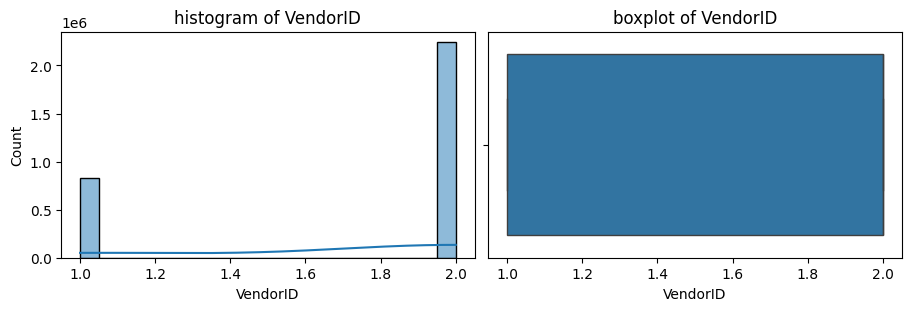

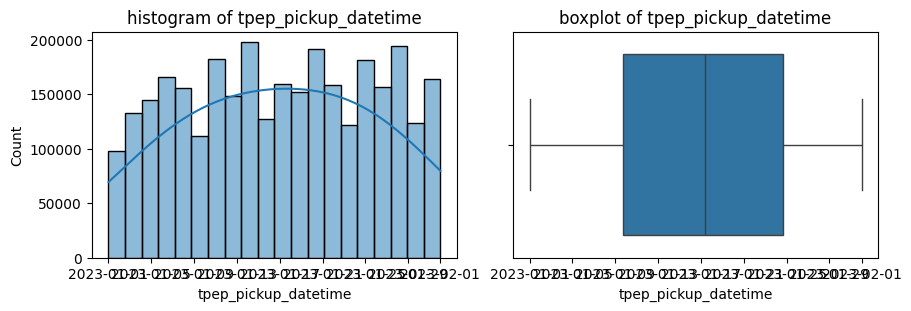

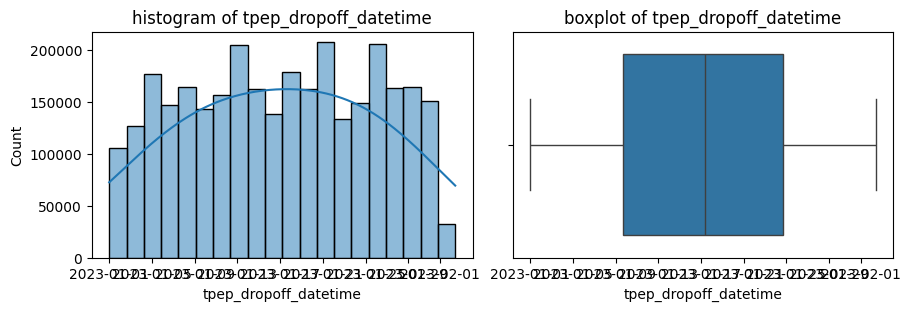

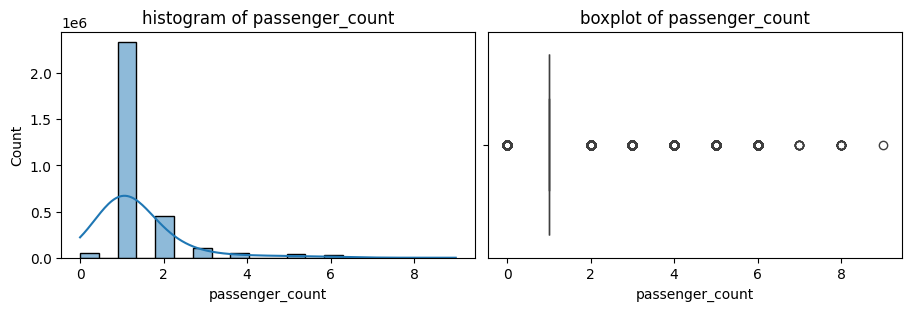

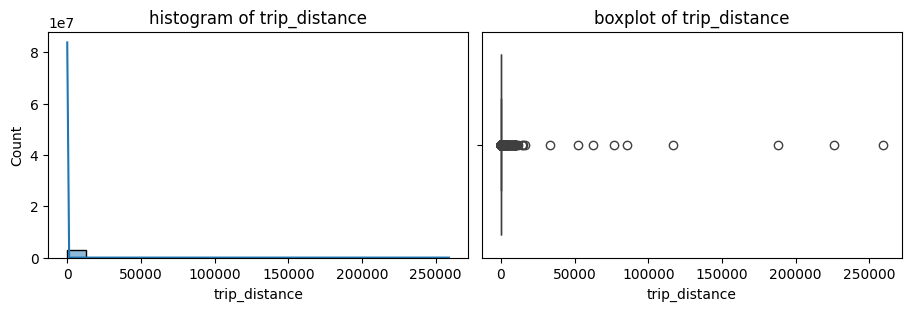

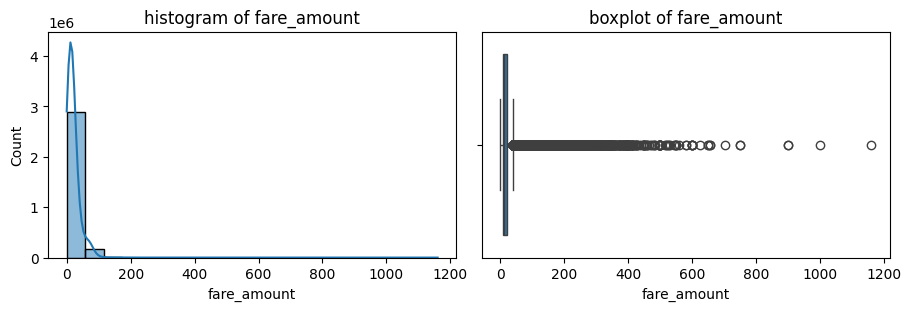

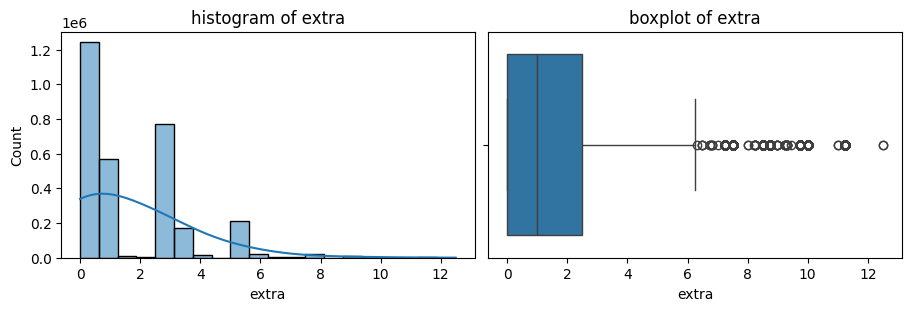

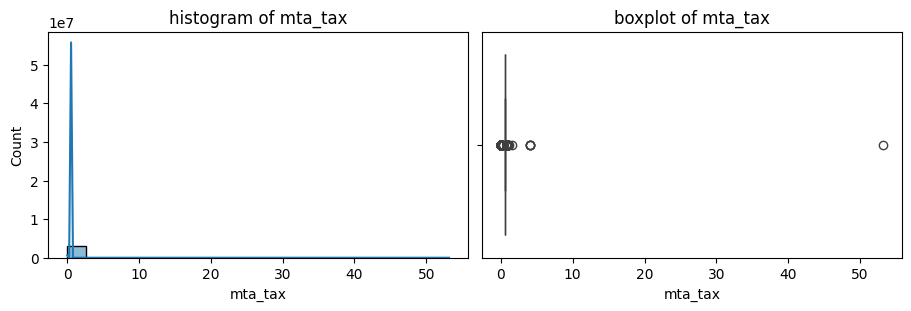

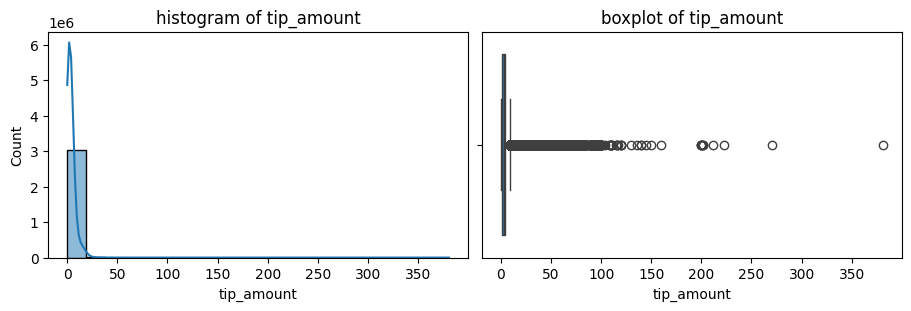

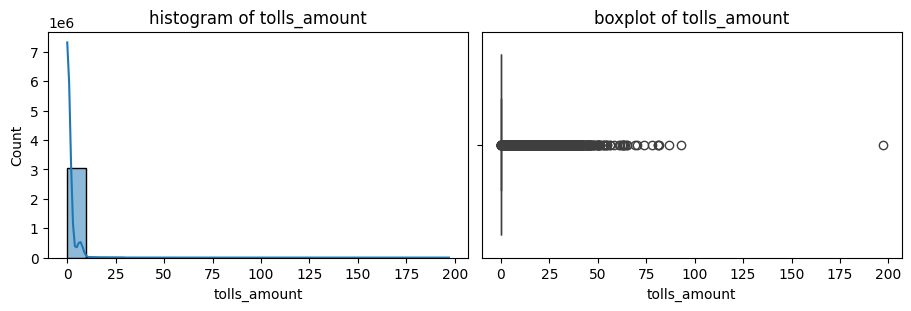

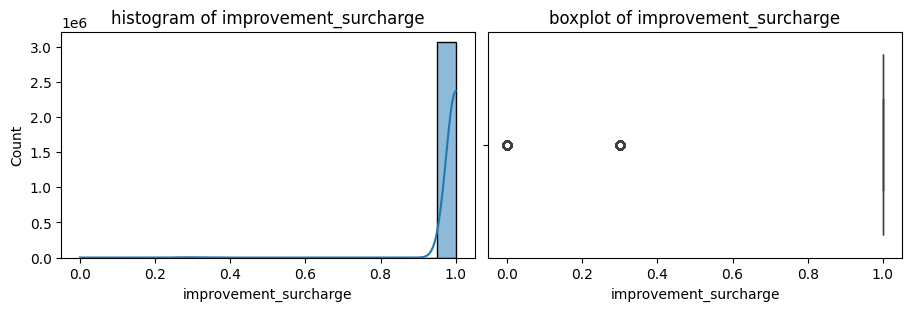

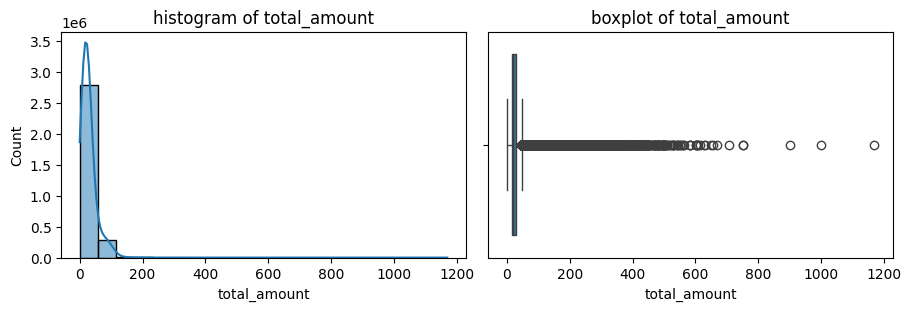

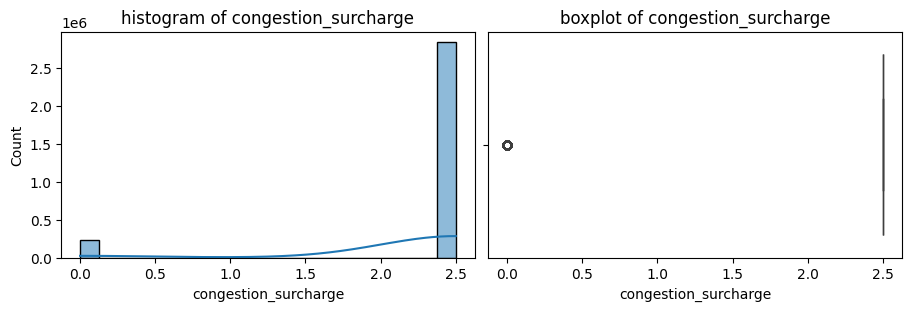

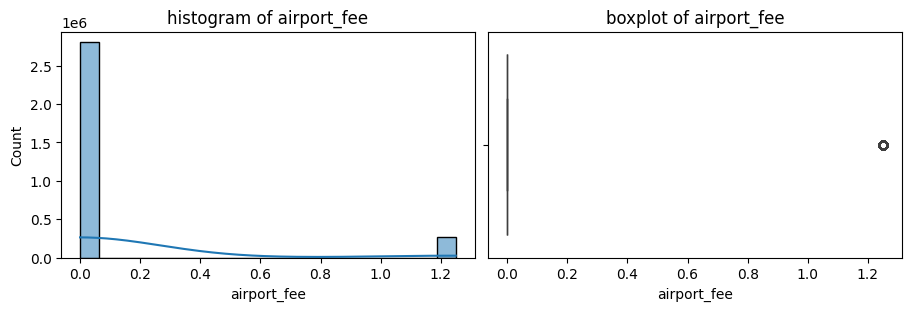

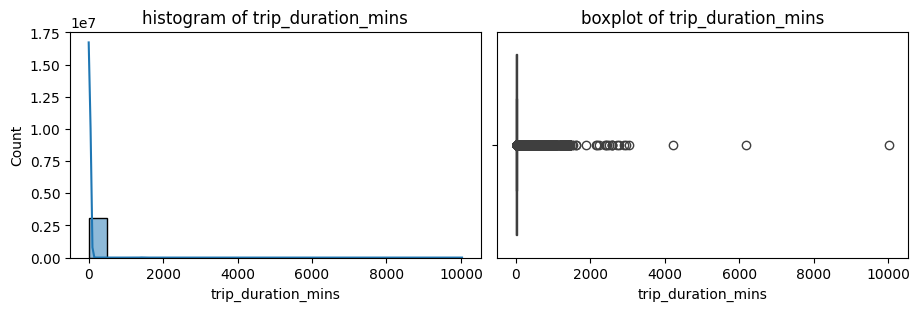

In [29]:
# list of numerical features
non_cat_columns = [column for column in main_df_3.columns if column not in cat_columns]

for col in non_cat_columns:
  fig, axs = plt.subplots(1,2,figsize=(9,3), layout="constrained")

  sns.histplot(x= main_df_3.loc[:,col], bins=20, ax=axs[0], kde=True, kde_kws={"bw_adjust": 15}) #plot histogram with a kernel density of 15 to observe distribution
  axs[0].set_title(f"histogram of {col}")
  sns.boxplot(x=main_df_3.loc[:,col], ax=axs[1]) #Create boxplot for further visualization of outliers 
  axs[1].set_title(f"boxplot of {col}")
  plt.xticks()
  plt.show() 

#### BASELINE MODEL SCORE

In [30]:
#copy dataframe into new data frame for feature engineering
main_df_4 = main_df_3.copy()
#Get day of week and hour of the day from trip pick up time
main_df_4["day_of_week"] = main_df_4["tpep_pickup_datetime"].dt.day_of_week
main_df_4["hour_of_day"] = main_df_4["tpep_pickup_datetime"].dt.hour

#drop the pickup and drop off time from the dataframe as the day and hour have been extracted
main_df_4 = main_df_4.drop(columns=["tpep_pickup_datetime","tpep_dropoff_datetime","VendorID"])

#encode the store_and_fwd_flag
main_df_4["store_and_fwd_flag"] = main_df_4["store_and_fwd_flag"].replace(to_replace=["Y","N"], value=[1,2])

main_df_4.head()



/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_19088/1289983084.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_df_4["store_and_fwd_flag"] = main_df_4["store_and_fwd_flag"].replace(to_replace=["Y","N"], value=[1,2])
/var/folders/0c/vr9_9rds4t10m_q7fxzlb3x00000gn/T/ipykernel_19088/1289983084.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  main_df_4["store_and_fwd_flag"] = main_df_4["store_and_fwd_flag"].replace(to_replace=["Y","N"], value=[1,2])


,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins,day_of_week,hour_of_day
0,1.0,0.97,1,2,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.43,6,0
1,1.0,1.10,1,2,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.32,6,0
2,1.0,2.51,1,2,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.75,6,0
3,0.0,1.90,1,2,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.62,6,0
4,1.0,1.43,1,2,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.83,6,0


In [32]:
#split dataframe into target and training set
X = main_df_4.copy()
Y = X.pop("trip_duration_mins")

#split into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state = 41)

#Scale Features using RobustScaler
rs = RobustScaler().fit(X_train)
X_train_transformed = rs.transform(X_train)
X_test_transformed = rs.transform(X_test)



In [33]:
def score_model(model, X_train, Y_train, X_test, Y_test):
    """ 
    This function takes in a fitted model; training and test set; 
    performs a 5 fold cross validation on the the training set provided with scores
    and finally scores the model prediciton. The model returns a dataframe of 
    the cross validation and score, the score for the actual prediction on the test set
    and an array of the prediction
    """

    scores = ["r2", "neg_mean_squared_error", "neg_root_mean_squared_error"]
    cv_score = cross_validate(model, X_train, Y_train, scoring=scores, cv=5)
    cv_score=pd.DataFrame(cv_score)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_pred,Y_test)
    mse = mean_squared_error(y_pred,Y_test)
    rmse = root_mean_squared_error(y_pred,Y_test)
    pred_df = pd.DataFrame(data=[r2,mse,rmse], index=["r2","mean_score","root_mean_score"])

    return cv_score, pred_df, y_pred

##### LINEAR REGRESSION

In [34]:
lr = LinearRegression()
lr.fit(X_train_transformed,Y_train)
lr_cv_scores, lr_pred_score, lr_y_pred = score_model(lr, X_train_transformed, Y_train, X_test_transformed, Y_test)


In [35]:
lr_cv_scores.head()

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.660728,0.013287,0.054769,-1582.830476,-39.784802
1,0.602426,0.008584,0.052863,-1650.143599,-40.621960
2,0.605238,0.006708,0.050055,-1703.311924,-41.271200
3,0.598678,0.006613,0.054332,-1602.844015,-40.035534
4,0.590244,0.008016,0.043112,-1969.130537,-44.374886


In [36]:
lr_pred_score.head()

,0
r2,-19.754894
mean_score,1909.864328
root_mean_score,43.701995


<Axes: ylabel='trip_duration_mins'>

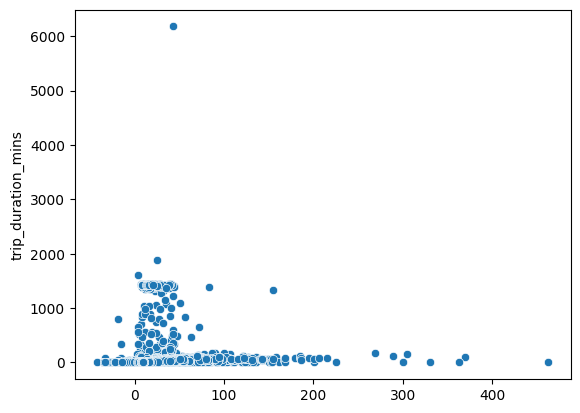

In [37]:
sns.scatterplot(x=lr_y_pred, y=Y_test)

##### RANDOM FOREST

In [38]:
rf = RandomForestRegressor(n_estimators=10, random_state=42)
rf.fit(X_train_transformed,Y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_pred,Y_test)
mse = mean_squared_error(y_pred,Y_test)
rmse = root_mean_squared_error(y_pred,Y_test)
pred_df = pd.DataFrame(data=[r2,mse,rmse], index=["r2","mean_score","root_mean_score"])
pred_df.head()

#rf_cv_scores, rf_pred_score, rf_y_pred = score_model(rf, X_train_transformed, Y_train, X_test_transformed, Y_test)

/Users/okundiakessy/Documents/All-things-Python/taxi-trip-duration-prediction/Taxi-Trip-Duration-Prediction-App/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


,0
r2,-2.015169
mean_score,4404.872527
root_mean_score,66.369214


<Axes: ylabel='trip_duration_mins'>

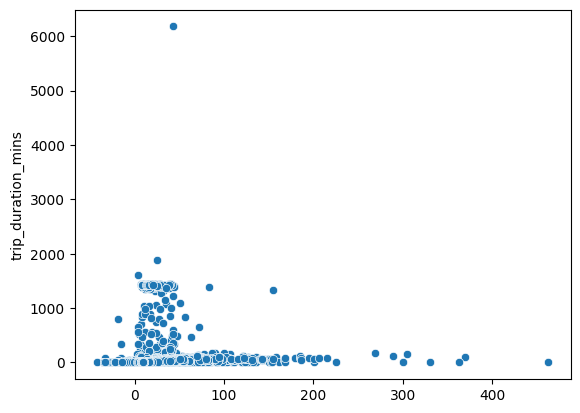

In [39]:
sns.scatterplot(x=lr_y_pred, y=Y_test)


##### RIDGE REGRESSION

In [41]:
rg = Ridge()
rg.fit(X_train_transformed,Y_train)

rg_cv_scores, rg_pred_score, rg_y_pred = score_model(rg, X_train_transformed, Y_train, X_test_transformed, Y_test)

In [42]:
rg_cv_scores.head()

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.378683,0.015961,0.054769,-1582.830457,-39.784802
1,0.288679,0.007322,0.052863,-1650.143623,-40.621960
2,0.214192,0.008100,0.050055,-1703.311961,-41.271200
3,0.243065,0.007091,0.054332,-1602.844010,-40.035534
4,0.216202,0.008189,0.043113,-1969.129012,-44.374869


In [43]:
rg_pred_score.head()

,0
r2,-19.754926
mean_score,1909.864373
root_mean_score,43.701995
